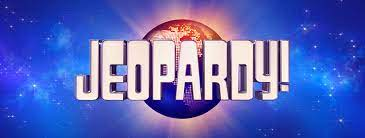

# Natural Language Processing with Jeopardy!
<br/>
Jeopardy! America's favorite quiz show.

Jeopardy, a daily episodic quiz show, has been around since 1984. It pits 3 contestants against each other to respond in the form of a question to a given clue. For those who may not know, Jeopardy consists of 2 rounds of 30 answers (which are actually the questions) that contestants need to be respond to in the form of a question (the answer in layman's terms). Both rounds consist of 6 categories, with 5 questions per category, increasing in dollar value incrementally as the contestants work their way down the game board. In the early years of Jeopardy, the values of first round questions ranged from \\$100 to \\$500, while the second round ranged from \\$600 to \\$1000, increasing by \\$100 with every question. In 2001, Jeopardy doubled the values of all of the questions, and it remains the same to this day. Each round also contains randomly placed "Daily Doubles," one in the first round and two in the second, where a contestant can wager up to and including their total earnings to that point or the maximum value of the top clue in that round, whichever is the greater value.

The contestants' goal is to accrue as much money as they can before the end of the second round, when they will once again wager any of their total earnings based on the category of the final clue. The winner of the final round is the contestant who retains or earns the highest dollar amount, whether or not the contestant got the final response correct. The winner keeps their earnings and is allowed to return as a champion for the next episode.

This project seeks to assemble the top categories used by Jeopardy over the years and use natural language processing to determine which category a given clue falls into.

Source: Game information mostly from personal knowledge; dates of changes pulled from Jeopardy Wikipedia

## Imports
All imports needed to run each workbook will be contained at the top of each page, just as you see here.

**NOTE:** There is a textstat library that will need to be installed in the first cell. Simply uncomment and run, or follow one of the provided links to the text stat documentation for install instructions.  
[textstat documentation](https://pypi.org/project/textstat/)  
[textstat conda installation instructions](https://anaconda.org/conda-forge/textstat)

In [ ]:
# Install if not already present in your packages
# !pip install textstat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textstat

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

pd.options.display.max_colwidth = 100
np.random.seed(42)

## Read in Data
Data was collected and compiled dating back to the first episode of Jeopardy on September 10, 1984. Included are several identifiers about the question: round of appearance, value of the correct answer, category, the question itself (referred to as asnswer), and the correct response (referred to as question). The data was found [here](https://www.kaggle.com/prondeau/350000-jeopardy-questions?select=master_season1-35.tsv) on kaggle.com and was uploaded approximately a year ago.

In [2]:
# This file is compressed in a .zip file and will need to be unpacked before running this line
# df = pd.read_csv('./datasets/master_season1-35.tsv', sep='\t')

# Checking the beginning of the data to get an idea of how the table looks.
df.head()

In [43]:
# Determining the stopping point or most recent data in the dataframe for comparison.
df.tail()

,round,value,daily_double,category,answer,question,air_date,answer_length,answer_word_count,syllable_count,sentence_count,dale_chall_score,processed_answer
349636,2,400,no,MAKE IT SNAPPY,"As well as photosharing on this app, you can watch its Snap originals like ""#vanlife\""",Snapchat,2019-07-26,86,15,21,1,7.54,"[well, photoshar, thi, app, watch, snap, origin, like, vanlif]"
349637,2,800,no,MAKE IT SNAPPY,"Genus Antirrhinum, these flowers snap closed after they are pried open by bees",snapdragons,2019-07-26,78,13,17,1,6.71,"[genu, antirrhinum, flower, snap, close, pri, open, bee]"
349638,2,1600,no,MAKE IT SNAPPY,This hyphenated tool company owns brands like Car-O-Liner & Kansas Jack,Snap-On,2019-07-26,71,11,20,1,8.87,"[thi, hyphen, tool, compani, brand, like, carolin, kansa, jack]"
349639,2,2000,no,MAKE IT SNAPPY,"In 2019 meteorologist Daryl Ritchison at NDSU, this university, said the minus-33 temps were ""a ...",North Dakota State University,2019-07-26,107,17,28,1,9.12,"[2019, meteorologist, daryl, ritchison, ndsu, thi, univers, said, minus33, temp, cold, snap]"
349640,3,0,no,HISTORIC SHIPS,"215 passengers were rescued when it sank in July 1918, about 500 fewer than it had rescued 6 yea...",the Carpathia,2019-07-26,106,20,28,1,7.79,"[215, passeng, rescu, sank, juli, 1918, 500, fewer, rescu, 6, year, earlier]"


## Data Exploration & Preprocessing

In [5]:
# Understant the shape of the dataset
df.shape

(349641, 9)

In [6]:
# Basic info on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349641 entries, 0 to 349640
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   round         349641 non-null  int64 
 1   value         349641 non-null  int64 
 2   daily_double  349641 non-null  object
 3   category      349641 non-null  object
 4   comments      349641 non-null  object
 5   answer        349641 non-null  object
 6   question      349641 non-null  object
 7   air_date      349641 non-null  object
 8   notes         349641 non-null  object
dtypes: int64(2), object(7)
memory usage: 24.0+ MB


In [7]:
# Summary statistics for the numerical columns
df.describe()

,round,value
count,349641.000000,349641.000000
mean,1.524730,759.706736
std,0.533749,671.050636
min,1.000000,0.000000
25%,1.000000,400.000000
50%,2.000000,600.000000
75%,2.000000,1000.000000
max,3.000000,25000.000000


In [8]:
# Check for null values
df.isnull().sum()

round           0
value           0
daily_double    0
category        0
comments        0
answer          0
question        0
air_date        0
notes           0
dtype: int64

In [9]:
# Drop columns
df = df.drop(columns=['comments', 'notes'])

These columns have no bearing on the target variable. The `comments` column contains the host's comments about the category, often a small quip or clarification to the prompt or its response. The `notes` column contains a description if the episode was a special airing, such as the Teen Tournament, or Tournament of Champions, when past winners would come back to compete for supremacy.

In [10]:
# Number of duplicate clues after the first is kept by default
len(df[df['answer'].duplicated() == True])

1421

In [11]:
# Remove duplicate clues
df = df.drop_duplicates(ignore_index=True)

In [12]:
# Number of dataframe entries that most often occur and how many times they appear.
df['category'].value_counts().head(25)

SCIENCE                    860
LITERATURE                 814
AMERICAN HISTORY           788
HISTORY                    720
SPORTS                     701
POTPOURRI                  699
BEFORE & AFTER             671
WORD ORIGINS               670
WORLD HISTORY              648
WORLD GEOGRAPHY            629
BUSINESS & INDUSTRY        596
U.S. CITIES                573
TRANSPORTATION             562
COLLEGES & UNIVERSITIES    550
RELIGION                   545
ART                        530
WORLD CAPITALS             513
ANIMALS                    507
U.S. GEOGRAPHY             503
U.S. HISTORY               499
BODIES OF WATER            493
AUTHORS                    491
BOOKS & AUTHORS            491
STATE CAPITALS             478
ISLANDS                    478
Name: category, dtype: int64

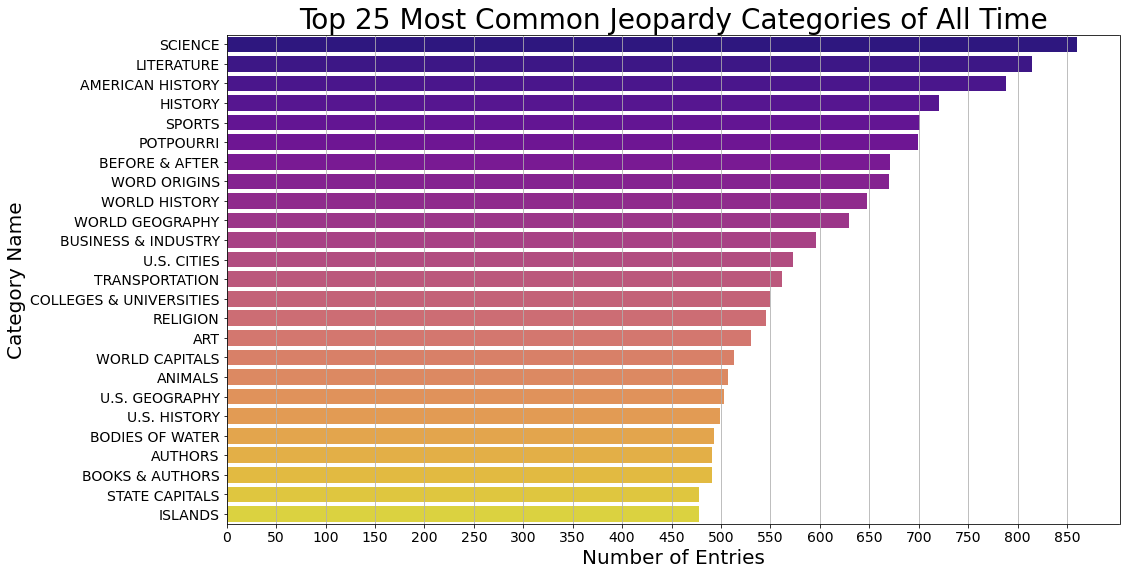

In [120]:
# Plotting the number of values in each of the top 25 appearing categories
x = df['category'].value_counts()[:25].values
y = df['category'].value_counts()[:25].index

plt.figure(figsize=(16,9))
sns.barplot(x=x, y=y, palette='plasma')
plt.xlabel('Number of Entries', size=20)
plt.ylabel('Category Name', size=20)
plt.xticks(np.arange(0,900, step=50), labels=np.arange(0,900, step=50), size=14)
plt.yticks(np.arange(0,25), labels=y, size=14)
plt.title('Top 25 Most Common Jeopardy Categories of All Time', size=28)
plt.grid(axis='x');

**Interpretation:**

The counts above show that Jeopardy tends to lean on categories that could be considered as academic concepts, with many categories appearing in a typical American curriculum. As any regular viewer of Jeopardy could attest, the remaining categories are a who's who of Jeopardy regulars, with Potpourri being the most notable, a hodgepodge of categories that often don't fit under a single umbrella or with no connections between one another. 

In [14]:
# Checking the top 25 responses of all time to see a pattern
df['question'].value_counts().head(25)

Australia       327
China           322
France          310
Japan           308
Chicago         306
California      283
India           281
Spain           278
Canada          269
Alaska          260
Mexico          250
Texas           234
Florida         231
Hawaii          230
Italy           230
Russia          224
Paris           220
South Africa    218
Brazil          216
New York        215
Germany         212
Ireland         208
Egypt           202
London          202
Sweden          202
Name: question, dtype: int64

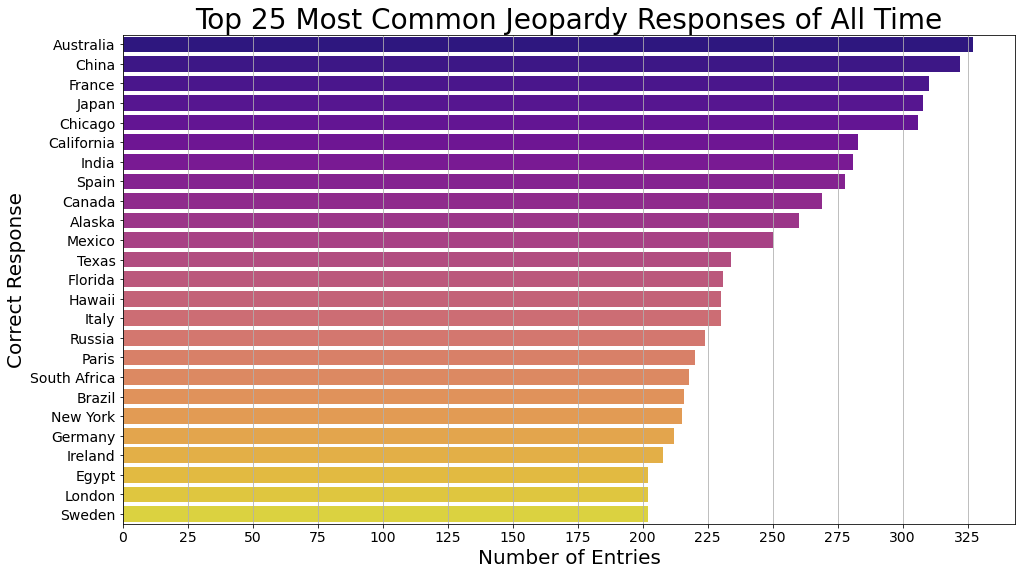

In [121]:
# Plotting the number of values in each of the top 25 appearing categories
x = df['question'].value_counts()[:25].values
y = df['question'].value_counts()[:25].index

plt.figure(figsize=(16,9))
sns.barplot(x=x, y=y, palette='plasma')
plt.xlabel('Number of Entries', size=20)
plt.ylabel('Correct Response', size=20)
plt.xticks(np.arange(0,350, step=25), labels=np.arange(0,350, step=25), size=14)
plt.yticks(np.arange(0,25), labels=y, size=14)
plt.title('Top 25 Most Common Jeopardy Responses of All Time', size=28)
plt.grid(axis='x');

**Interpretation:**

In addition to examining the top appearing categories, the top question responses we re looked at. These responses show that Jeopardy really leans into the same set of geographical related responses in several of its episodes, perhaps due to being able to pull many facts from looking in the details of a state or country. 

In [15]:
# Create new columns to show character count and word counts in the dataframe
df['answer_length'] = [len(answer) for answer in df['answer']]
df['answer_word_count'] = [len(answer.split()) for answer in df['answer']]

df.head()

,round,value,daily_double,category,answer,question,air_date,answer_length,answer_word_count
0,1,100,no,LAKES & RIVERS,River mentioned most often in the Bible,the Jordan,1984-09-10,39,7
1,1,200,no,LAKES & RIVERS,Scottish word for lake,loch,1984-09-10,22,4
2,1,400,no,LAKES & RIVERS,American river only 33 miles shorter than the Mississippi,the Missouri,1984-09-10,57,9
3,1,500,no,LAKES & RIVERS,"World's largest lake, nearly 5 times as big as Superior",the Caspian Sea,1984-09-10,55,10
4,1,100,no,INVENTIONS,Marconi's wonderful wireless,the radio,1984-09-10,28,3


In [16]:
# Summary statistics of the new columns
df[['answer_length', 'answer_word_count']].describe()

,answer_length,answer_word_count
count,349641.000000,349641.000000
mean,79.495136,14.089655
std,26.091527,4.890250
min,1.000000,1.000000
25%,64.000000,11.000000
50%,84.000000,15.000000
75%,99.000000,17.000000
max,311.000000,52.000000


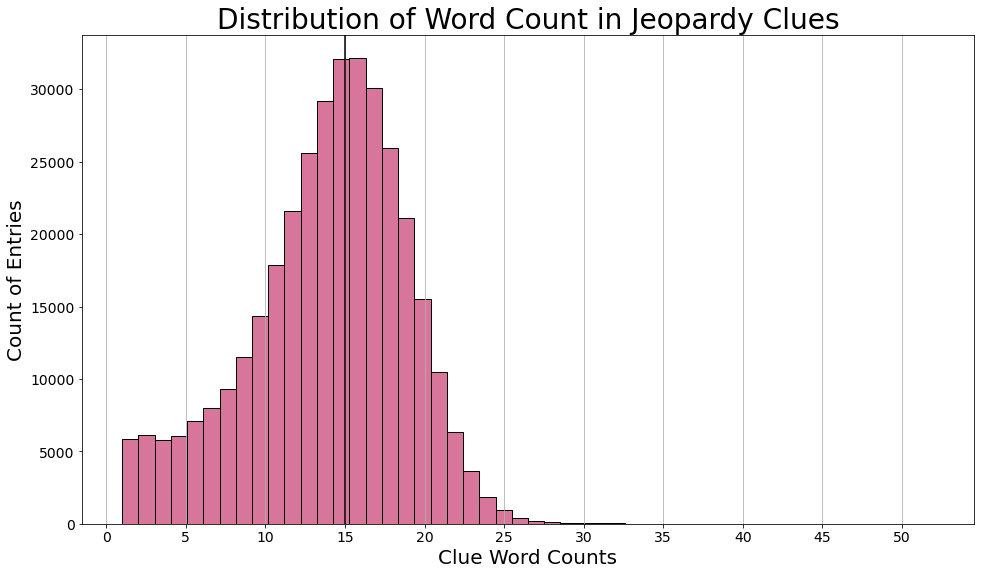

In [129]:
# Plotting the distribution of word counts across the data
plt.figure(figsize=(16,9))

sns.histplot(data=df[['answer_word_count']],
            bins=50,
            palette='plasma',
            legend=False)
plt.xlabel('Clue Word Counts', size=20)
plt.ylabel('Count of Entries', size=20)
plt.xticks(np.arange(0,55, step=5), labels=np.arange(0,55, step=5), size=14)
plt.yticks(np.arange(0,35000, step=5000), labels=np.arange(0,35000, step=5000), size=14)
plt.title('Distribution of Word Count in Jeopardy Clues', size=28)
plt.axvline(df['answer_word_count'].median(), color='black')
plt.grid(axis='x');

# Median line code refresher from: https://stackoverflow.com/a/67019620

**Interpretation:**

The above histogram shows the distribution of the word counts of the clue prompt through the full dataframe. It shows a fairly normal distribution with some outliers toward the higher range, which is confirmed by the summary statistics above. The assumption would be for the clues to have a relatively short length overall as the program does have a 30 minute run-time. The majority of the clues fall within the 10-20 range with the median falling on 15 words in the clue, confirming the assumptions made above. 

In [18]:
# Calculating the averages of question length for each year of the show to look for a trend.
years = range(1984, 2020)

yearly_mean = []
for year in years:
    items = {}
    temp = df[df['air_date'].str.contains(str(year))]
    items['show_year'] = 'season' + str(year)
    items['avg_answer_length'] = temp['answer_length'].mean()
    items['avg_word_count'] = temp['answer_word_count'].mean()
    yearly_mean.append(items)
    
avg_by_year = pd.DataFrame(yearly_mean)

In [19]:
# Checking that each year is accounted for
print(avg_by_year.shape)
avg_by_year.describe()

(36, 3)


,avg_answer_length,avg_word_count
count,36.000000,36.000000
mean,78.673825,13.931954
std,4.537203,0.838435
min,56.821084,9.903012
25%,78.256710,13.894449
50%,79.252315,14.029221
75%,80.160588,14.222450
max,86.096247,15.306229


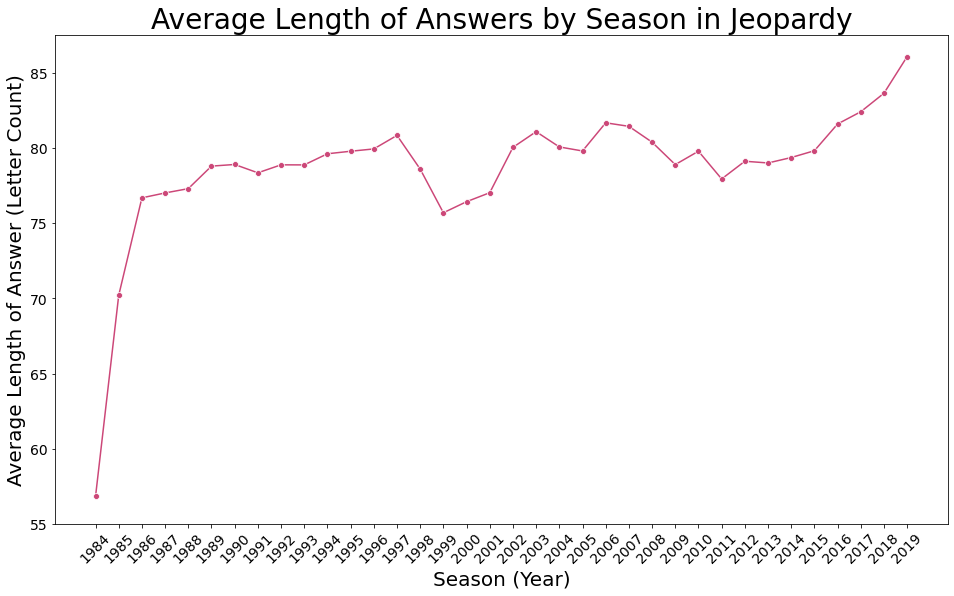

In [20]:
# Plotting the average character count per season (year)
plt.figure(figsize=(16,9))

sns.lineplot(data=avg_by_year[['avg_answer_length']], 
            palette='plasma', 
            legend=False,
            markers=True)
plt.xlabel('Season (Year)', size=20)
plt.ylabel('Average Length of Answer (Letter Count)', size=20)
plt.xticks(np.arange(0,36), labels=np.arange(1984, 2020), rotation=45, size=14)
plt.yticks(np.arange(55,88, step=5), size=14)
plt.title('Average Length of Answers by Season in Jeopardy', size=28);

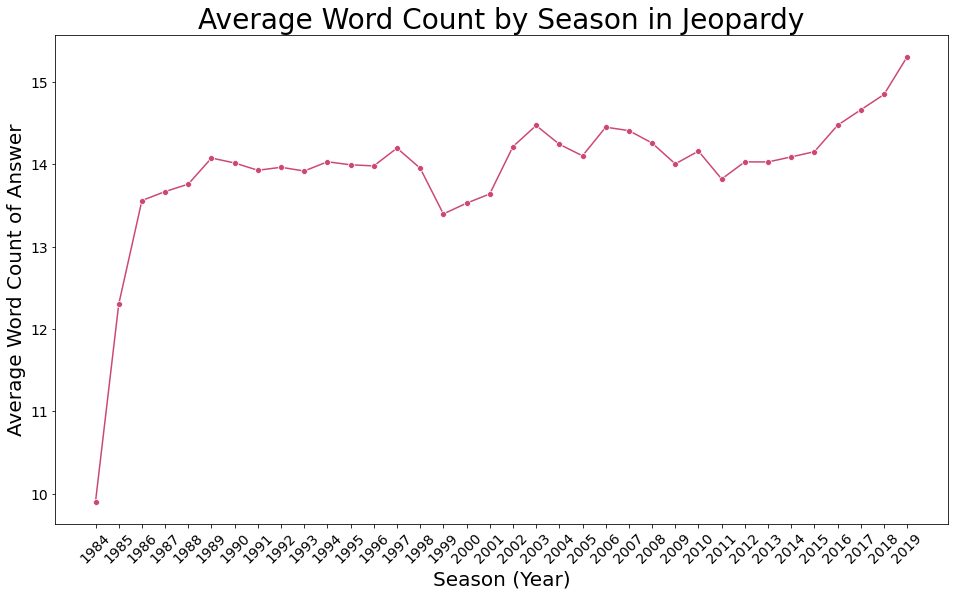

In [21]:
# Plotting the average word count per season (year)
plt.figure(figsize=(16,9))

sns.lineplot(data=avg_by_year[['avg_word_count']], 
             palette='plasma', 
             legend=False, 
             markers=True)
plt.xlabel('Season (Year)', size=20)
plt.ylabel('Average Word Count of Answer', size=20)
plt.xticks(np.arange(0,36), labels=np.arange(1984, 2020), rotation=45, size=14)
plt.yticks(np.arange(10,16), size=14)
plt.title('Average Word Count by Season in Jeopardy', size=28);

**Interpretation:**

The above two charts plot the average verbosity of the prompts over the lifetime of Jeopardy. Both plots show that the length of Jeopardy answers (questions) has increased over the years. One could speculate that the increase in verbosity could be due to a number of causes: general difficulty of the questions has increased as the years go on, technological advances from 1984 to 2019 have increased the size of content which can be displayed on a screen, or better question writers on the research team were added as the game grew in popularity. The graphs show a sharp increase from seasons 1 to  2 and a less marked increase from seasons 2 to 3 before the fluctuations start to flatten out. Overall, throughout the years, an apparent upward trend does exist when looking at the length of questions.

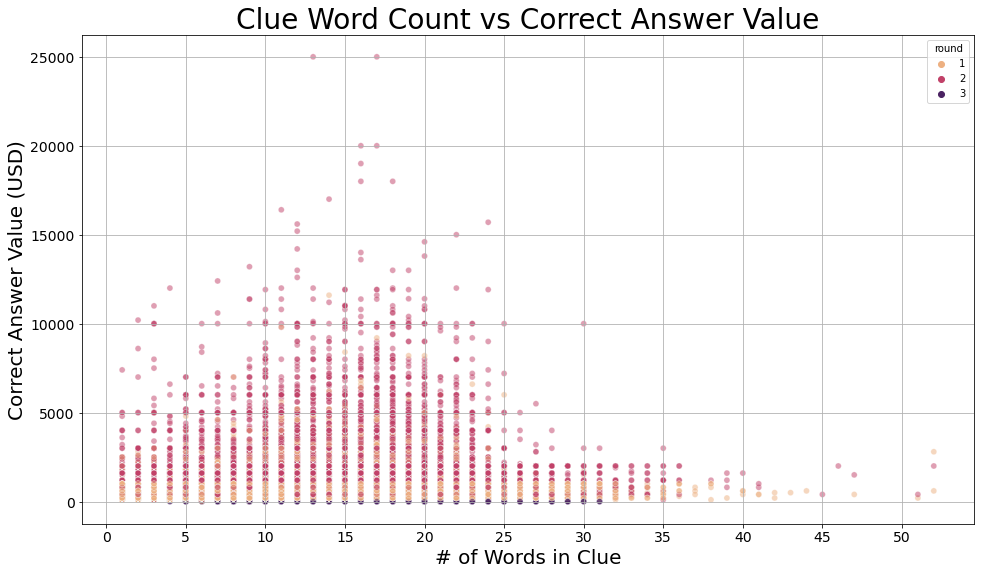

In [137]:
# Cheching for any trend or pattern between word count and pattern
plt.figure(figsize=(16,9))

sns.scatterplot(data=df, 
                x='answer_word_count', 
                y='value', 
                palette='flare', 
                hue='round', 
                alpha=0.5)
plt.xlabel('# of Words in Clue', size=20)
plt.ylabel('Correct Answer Value (USD)', size=20)
plt.xticks(np.arange(0,55, step=5), label=np.arange(0,55, step=5), size=14)
plt.yticks(np.arange(0,25001, step=5000), label=y.values, size=14)
plt.title('Clue Word Count vs Correct Answer Value', size=28)
plt.grid();

**Interpretation:**  

Here I was searching for any linear trend between the clue word count and the value of a correct answer. The chart is showing no linear trend since all of the plots are concentrated more toward the lower left quadrant of the plot. The presumed outliers high on the y axis come primarily from the Daily Double clues in Round 2 of the show, where a contestant can wager any of their earnings to that point. At times, bold players will wager large amounts to either close the gap with the leader or to distance themselves from the rest of the pack to make the Final Jeopardy wager moot. Surprising to me is that there are not as many large wagers in Final Jeopardy, noted by the dark points of Round 3. Several of these clues have closer to a \\$0 value, meaning more often than not, contestants bet \\$0 on the final clue.

## Feature Engineering with Textstat Library
From [https://pypi.org/project/textstat/](https://pypi.org/project/textstat/):
>Textstat is an easy to use library to calculate statistics from text. It helps determine readability, complexity, and grade level.  

Below, I will be creating some new features with the textstat library in order to check for correlations through the data. I will be creating new columns names `syllable_count` and `sentence_count` to correspond with the word count and character count above. The assumption here is that these new columns will correlate almost identically with the data as the previously created columns had.  

Additionally, I will be creating a column called `dale_chall_score` which measures the readability of the document and returns a score that correlates to the reading skill at a given grade-level. More about the Dale-Chall Readability score is shown below.

In [23]:
# Testing new textstat package on one row before moving on to full dataframe.
print(textstat.syllable_count(df['answer'][0], lang='en_US'))
print(textstat.sentence_count(df['answer'][0]))
print(textstat.dale_chall_readability_score(df['answer'][0]))

10
1
6.24


In [24]:
# Create new features using textstat library
df['syllable_count'] = [textstat.syllable_count(x) for x in df['answer']]
df['sentence_count'] = [textstat.sentence_count(x) for x in df['answer']]

In [25]:
# Explanation on this feature below
df['dale_chall_score'] = [textstat.dale_chall_readability_score(a) for a in df['answer']]

In [26]:
df['dale_chall_score'].head()

0     6.24
1     7.78
2     7.59
3     5.71
4    14.31
Name: dale_chall_score, dtype: float64

### Dale Chall Readability Score Explained:
The Dale–Chall readability formula is a readability test that provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text. It uses a list of 3000 words that groups of fourth-grade American students could reliably understand, considering any word not on that list to be difficult.

<br/><br/>

**<div align="center">Formula for Dale-Chall Readability Scoring</div>**<br/>

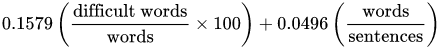

<br/><br/>

|**Score**|**Understood by:**|
|---|---|
|4.9 or lower|average 4th-grade student or lower|
|5.0 - 5.9|average 5th or 6th-grade student|
|6.0 - 6.9|average 7th or 8th-grade student|
|7.0 - 7.9|average 9th or 10th-grade student|
|8.0 - 8.9|average 11th or 12th-grade student|
|9.0 - 9.9|average 13th to 15th-grade (college) student|
|10 and above|average 16th-grade and above (college graduate)


source: [Dale-Chall Readability Score on Wikipedia](https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula)

In [41]:
# Checking the ratio of graduate-level rated questions to the rest.
dc_higher = len(df[df['dale_chall_score'] >= 10])
dc_lower = len(df[df['dale_chall_score'] < 10])

print(f"The number of rows with a Dale-Chall score greater than 10 is: {dc_higher}.")
print(f"The number of rows with a Dale-Chall score lower than 10 is: {dc_lower}.")

grad_pct = str(round(dc_higher / len(df['dale_chall_score']) * 100, 2)) + '%'

print(f'The ratio of college graduate rated clues to the total is {grad_pct}.')

The number of rows with a Dale-Chall score greater than 10 is: 41426.
The number of rows with a Dale-Chall score lower than 10 is: 308215.
The ratio of college graduate rated clues to the total is 11.85%.


In [149]:
dc_4 = round(len(df[df['dale_chall_score'] < 5]) / len(df['dale_chall_score']), 2)
dc_5 = round(len(df[df['dale_chall_score'].between(5,6)]) / len(df['dale_chall_score']), 2)
dc_6 = round(len(df[df['dale_chall_score'].between(6,7)]) / len(df['dale_chall_score']), 2)
dc_7 = round(len(df[df['dale_chall_score'].between(7,8)]) / len(df['dale_chall_score']), 2)
dc_8 = round(len(df[df['dale_chall_score'].between(8,9)]) / len(df['dale_chall_score']), 2)
dc_9 = round(len(df[df['dale_chall_score'].between(9,10)]) / len(df['dale_chall_score']), 2)
dc_10 = round(len(df[df['dale_chall_score'] >= 10]) / len(df['dale_chall_score']), 2)

# Code adapted from: https://stackoverflow.com/a/40442778

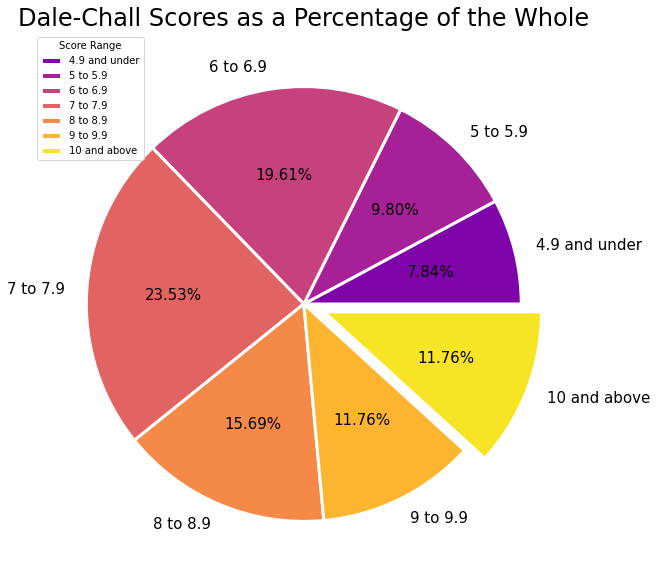

In [204]:
slices = [dc_4, dc_5, dc_6, dc_7, dc_8, dc_9, dc_10]
labels = '4.9 and under', '5 to 5.9', '6 to 6.9', '7 to 7.9', '8 to 8.9', '9 to 9.9', '10 and above'
color = plt.cm.plasma(np.linspace(0.25, 0.95, 7))
wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'}
textprops = {'fontsize':15}

plt.figure(figsize=(10,10))

plt.pie(slices, 
       labels=labels, 
       wedgeprops=wedgeprops,
       textprops=textprops,
       colors=color,
       autopct='%0.2f%%',
       explode=(0, 0, 0, 0, 0, 0, 0.1))
plt.title('Dale-Chall Scores as a Percentage of the Whole', size=24)
plt.legend(title='Score Range', loc='upper left')
plt.show();

# Colormap adapted from: https://stackoverflow.com/a/45508225
# Autopct guide from: https://stackoverflow.com/a/64496742
# Textprops guide from  https://stackoverflow.com/a/51301539

**Interpretation:**

Above, I wanted to see Dale-Chall scores as parts of the whole. Once again, as noted above also, Jeopardy tends to lean heavily into academic themed clues, and we also saw that above when looking at our top 25 categories of all time. Here we see that Jeopardy tends to keep its readability around a 9th to 10th-grade level for the majority of it's clues. The next 7.0 to 7.9 score range corresponds to that. What is also notable, is that almost 12% of Jeopardy clues fall into a post graduate reading level. We're going to take a better look at that below. 

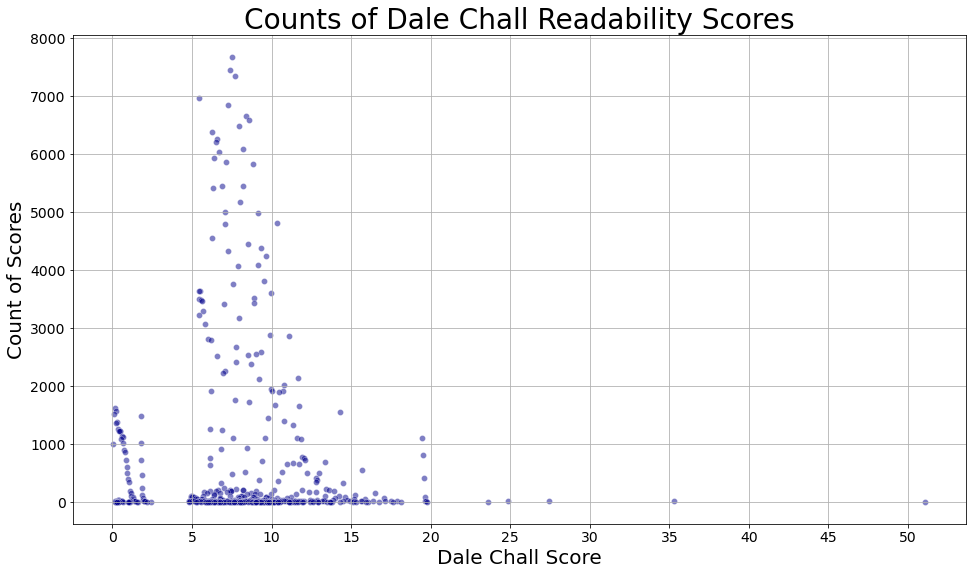

In [94]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df['dale_chall_score'].value_counts(), 
                color='darkblue', 
                alpha=0.5)
plt.xlabel('Dale Chall Score', size=20)
plt.ylabel('Count of Scores', size=20)
plt.xticks(np.arange(0,55, step=5), labels=np.arange(0,55, step=5), size=14)
plt.yticks(np.arange(0,8001, step=1000), labels=np.arange(0,8001, step=1000), size=14)
plt.title('Counts of Dale Chall Readability Scores', size=28)
plt.grid();

**Interpretation:**

The above chart shows the value counts of the Dale Chall Readability scores. In other words, it's showing how many times a specific score appears throughout the data. The majority of scores had a low appearance count, but one item of note is how many clues fall if the 5-10 score range, with the highest count falling right around 7. The provided chart above notes that a score between 7 and 8 indicate a 9th to 10th grade reading level, meaning the clues aren't very high level or advanced on average.  

Some specific standouts are the single score coming in at over 50 and any other above the tight grouping that stops around 17. Any score over 10 indicates a post graduate level readability, so I've isolated a sampling of the highest scores on the chart to look for any patterns. Immediately, we can see from the isolated clues below that the category LITERARY E-MAIL ADDRESSES appears most often. Additionally, all of the clues have some sort of special characters in them and mostly contain no spaces, which is likely what is tripping up the algorithm.

In [194]:
df[df['dale_chall_score'] > 10].sort_values(by='dale_chall_score', ascending=False)[:10]

,round,value,daily_double,category,answer,question,air_date,answer_length,answer_word_count,syllable_count,sentence_count,dale_chall_score,processed_answer
243609,2,1600,no,LITERARY E-MAIL ADDRESSES,naval-historian-action-guy@clancy.cia.gov,Jack Ryan,2011-01-05,41,1,11,1,51.06,[navalhistorianactionguyclancyciagov]
295531,1,200,no,STATE CAPITAL HEADQUARTERS,Coca-Cola,Atlanta,2015-03-03,9,1,4,1,35.27,[cocacola]
328850,1,800,no,THE STATE UNIVERSITY IN...,Urbana-Champaign,the University of Illinois,2017-12-07,16,1,3,1,35.27,[urbanachampaign]
243607,2,800,no,LITERARY E-MAIL ADDRESSES,aka-smeagol@my-precious.info,Gollum,2011-01-05,28,1,6,1,35.27,[akasmeagolmypreciousinfo]
243608,2,2500,yes,LITERARY E-MAIL ADDRESSES,ageless-wonder@wilde-pictures.com,Dorian Gray,2011-01-05,33,1,7,1,35.27,[agelesswonderwildepicturescom]
243610,2,2000,no,LITERARY E-MAIL ADDRESSES,diarist@1984ministry-of-truth.gov,Winston Smith,2011-01-05,33,1,5,1,35.27,[diarist1984ministryoftruthgov]
280525,1,800,no,BEASTLY TITLE CHARACTERS,"\""Rikki-Tikki-Tavi\""",a mongoose,2013-12-25,20,1,3,1,35.27,[rikkitikkitavi]
108043,1,500,no,"BEGINS & ENDS IN ""C\""",Cancer-causing,carcinogenic,2000-03-30,14,1,4,1,35.27,[cancercaus]
91927,1,100,no,COUNTRIES IN FRENCH,Nouvelle-Zelande,New Zealand,1999-01-29,16,1,3,1,35.27,[nouvellezeland]
155375,1,200,no,ALPHABETIC HOMOPHONES,Supermodel-actress Macpherson,Elle,2003-12-30,29,2,7,1,27.42,"[supermodelactress, macpherson]"


In [29]:
'''
This loop maps the average Dale-Chall readability
score by year to see if a trend exists from year 
to year in the supposed difficulty of clues.
'''

years = range(1984, 2020)

dc_scores = []
for year in years:
    result = {}
    temp = df[df['air_date'].str.contains(str(year))]
    result['show_year'] = 'season' + str(year)
    result['avg_dc_score'] = temp['dale_chall_score'].mean()
    result['min_dc_score'] = temp['dale_chall_score'].min()
    result['max_dc_score'] = temp['dale_chall_score'].max()
    dc_scores.append(result)
    
yearly_dc = pd.DataFrame(dc_scores)

In [30]:
yearly_dc.describe()

,avg_dc_score,min_dc_score,max_dc_score
count,36.000000,36.000000,36.000000
mean,7.490845,0.054167,23.618611
std,0.095283,0.018420,7.260429
min,7.305837,0.050000,19.480000
25%,7.431272,0.050000,19.620000
50%,7.486796,0.050000,19.670000
75%,7.547456,0.050000,24.840000
max,7.715944,0.150000,51.060000


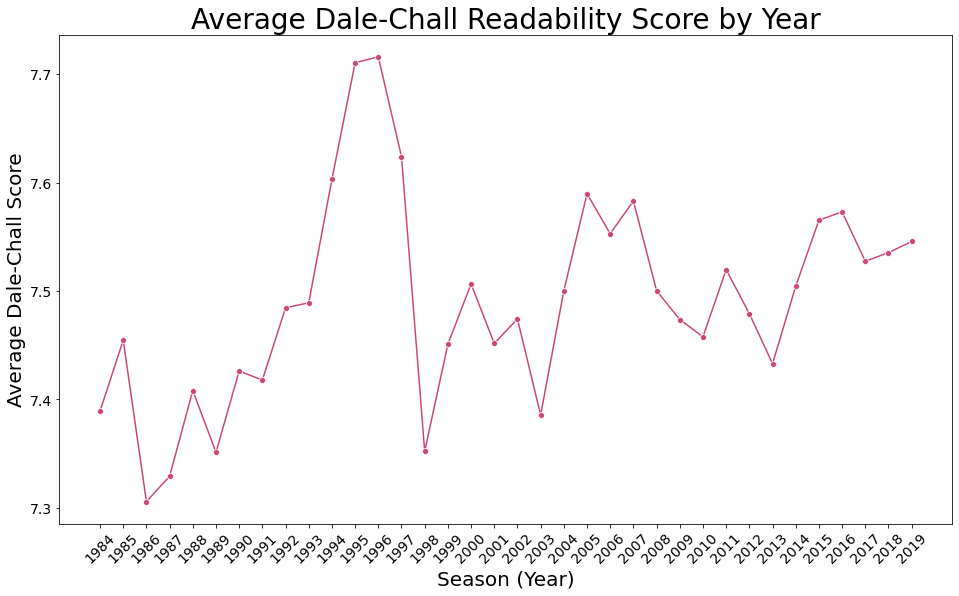

In [33]:
plt.figure(figsize=(16,9))

sns.lineplot(data=yearly_dc[['avg_dc_score']],
            palette='plasma',
            markers=True,
            legend=False)
plt.xlabel('Season (Year)', size=20)
plt.ylabel('Average Dale-Chall Score', size=20)
plt.xticks(np.arange(0,36), labels=np.arange(1984, 2020), rotation=45, size=14)
plt.yticks(np.arange(7.3,7.8, step=0.1), size=14)
plt.title('Average Dale-Chall Readability Score by Year', size=28);

**Interpretation:**

The above chart was used to check if the Dale-Chall readability score increased or decreased substantially through the years. The chart is deceptive because it appears to show wild fluctuations throughout the years, but upon closer look, the range only falls between 7.3 and about 7.8, which would appear very flat on a larger scale chart. This would mean that the average difficulty in understanding and reading the clues in Jeopardy through the years has not changed, and only individual episodes vary in difficulty, which can be seen in the summary statistics shown above.

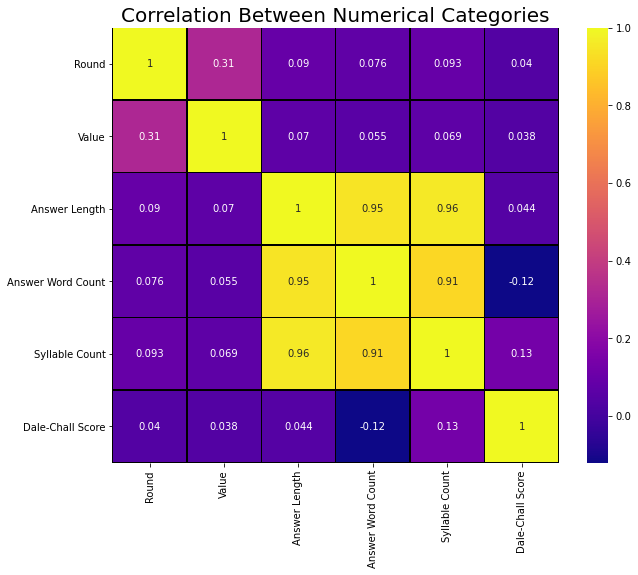

In [28]:
cols = ['round', 'value', 'answer_length', 'answer_word_count', 
        'syllable_count', 'dale_chall_score']
ax_labels = ['Round', 'Value', 'Answer Length', 'Answer Word Count',
            'Syllable Count', 'Dale-Chall Score']

plt.figure(figsize=(10,8))

sns.heatmap(df[cols].corr(),
           annot=True,
           cmap='plasma',
           linewidth=0.5,
           linecolor='black')
plt.xticks(ticks=np.arange(0.5,6.5), labels=ax_labels)
plt.yticks(ticks=np.arange(0.5,6.5), labels=ax_labels)
plt.title('Correlation Between Numerical Categories', size=20);

**Interpretation:**

Checking the correlations between the numerical columns gives mostly expected results. The block of high correlations in the center all deal with the length of the clue: character count, word count, and syllable count, all of which would produce a high correlation with one another as they are all measuring the same thing in different ways. This chart was mainly to check correlation between the columns compared to the newly created Dale-Chall Score column. The assumption was that the scoring in the Dale-Chall column would have a high correlation with the question value or which round the question fell into, as the Double Jeopardy (second) round should presumably have more difficult clues. However, the readability scores seem to have no direct correlation to the value of a question as evidenced by the results above. 

## Data Preprocessing

1. Make all text lowercase
2. Remove special characters 
3. Tokenize
4. Lemmatize
5. Remove stopwords

In [34]:
# RegEx portion of this code adapted from https://stackoverflow.com/a/22521235
# Refresher on processing tools taken from Lesson 5.03
def process(series):
    '''
    Takes in a string of text and executes the following:
    1. Removes all non-alphanumeric characters
    2. Tokenize and convert to lowercase
    3. Lemmatize each token
    4. Stems each token
    5. Remove all stopwords
    6. Append finished document to a list
    7. Convert list to a series for use in a dataframe
    '''
    finished_process = []
    for x in series:
        x = re.sub('[^a-zA-Z0-9 ]', '', x)
        x = word_tokenize(x.lower())
        lemmatizer = WordNetLemmatizer()
        x_tokens = [lemmatizer.lemmatize(token) for token in x]
        stemmer = PorterStemmer()
        x_stem = [stemmer.stem(lem) for lem in x_tokens]
        x_stop = [stem for stem in x_stem if stem not in stopwords.words('english')]
        finished_process.append(x_stop)
        
    return pd.Series(finished_process)

In [35]:
df['processed_answer'] = process(df['answer'])

In [36]:
df.head(1)

,round,value,daily_double,category,answer,question,air_date,answer_length,answer_word_count,syllable_count,sentence_count,dale_chall_score,processed_answer
0,1,100,no,LAKES & RIVERS,River mentioned most often in the Bible,the Jordan,1984-09-10,39,7,10,1,6.24,"[river, mention, often, bibl]"


In [37]:
# Filter a new dataframe to the top 25 categories which will become the classification target.
target_cats = list(df['category'].value_counts()[:25].index)
df_25 = df[df['category'].isin(target_cats)]

In [38]:
df_25['question'].value_counts().head(25)

Australia         36
Boston            31
China             28
Alaska            27
Honolulu          27
New Orleans       25
Japan             25
Greenland         24
Cuba              23
Canada            23
Maine             22
Florida           20
California        20
Chicago           19
Buddhism          19
Hawaii            19
Antarctica        19
India             19
Islam             19
Atlanta           18
Mexico            18
Brazil            18
Texas             18
New Zealand       18
Salt Lake City    18
Name: question, dtype: int64

**Interpretation:**

The value count of the correct responses from the new dataframe show that the trend of geographical related responses fits throughout the top 25 categories just like it did in the full dataset. Geography has often been a frequent topic in Jeopardy through years of personal experience. The data here confirms suspicions.

In [39]:
df_25.describe()

,round,value,answer_length,answer_word_count,syllable_count,sentence_count,dale_chall_score
count,15009.000000,15009.000000,15009.000000,15009.000000,15009.000000,15009.000000,15009.000000
mean,1.627090,630.624159,83.272370,14.610833,20.608968,1.029782,7.661600
std,0.553496,602.551920,18.363211,3.526872,4.877183,0.174632,2.155313
min,1.000000,0.000000,6.000000,1.000000,2.000000,1.000000,0.100000
25%,1.000000,200.000000,72.000000,12.000000,17.000000,1.000000,6.490000
50%,2.000000,400.000000,85.000000,15.000000,21.000000,1.000000,7.590000
75%,2.000000,800.000000,96.000000,17.000000,24.000000,1.000000,8.870000
max,3.000000,14600.000000,226.000000,40.000000,54.000000,3.000000,19.480000


In [40]:
# Save processed dataframes to be used in modeling
df.to_csv('./datasets/jeopardy_processed.csv', index=False)
df_25.to_csv('./datasets/top_25_processed.csv', index=False)